In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem.rdmolfiles import SDMolSupplier
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
import re
import random

In [2]:
#1: This program shows how to extract a library of bipyridine sidechains from an open-source csv file containg about 
#   10 000 bipyridine ligand

In [39]:
#First step: extract the bipyridines from the csv file and convert it into a list of Rd-kit Mol objects
df=pd.read_csv('/Users/tarrago/Downloads/PubChem_compound_text_bipyridine_summary.csv')
suppl=df['isosmiles'].values
mol=[]
for m1 in suppl:
    Dumdum=Chem.MolFromSmiles(m1)
    mol.append(Dumdum)

RDKit WARNING: [11:01:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:01:10] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [11:01:10] Explicit valence

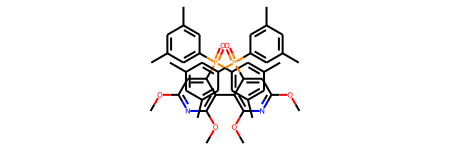

In [11]:
# the list mol contains 11410 bipyridine. However, some of them are counted twice, some of them don't actually
# contain bipyridines, and some of them contain
# two molecules or more. In the next step, we want to get rid of the intruder molecules, not containing any 
#2,2-bipyridine. For instance:
mol[11]

In [45]:
# So here is a chunk of code to get rid of all non-conform objects:
sub=Chem.MolFromSmiles('C1=CC=NC(=C1)C2=CC=CC=N2')
ndoubles=[]
print(len(mol))
i=0
while i < len(mol):
    # Here the code gets rid of all objects containing either nothing, or no 2,2-bipyridine
    if str((type(mol[i]))) != "<class 'rdkit.Chem.rdchem.Mol'>":
        mol.remove(mol[i])
    elif len(mol[i].GetSubstructMatches(sub)) == 0:
        mol.remove(mol[i])
    else:
        S1=Chem.MolToSmiles(mol[i])
        # This part gets rid of the extra molecules if there are more than one molecule in the fragment. Note that
        # if several bipyridines are present in the object, only the last one will be kept.
        if "." in S1:
            Split=S1.split('.')
            for j in range(0,len(Split)):
                dumdum=Chem.MolFromSmiles(Split[j])
                if len(dumdum.GetSubstructMatches(sub)) == 1:
                    mol[i]=dumdum
  
        i = i+1


7143


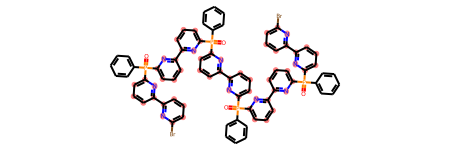

In [51]:
#Finally, for simplicity reason, we want to get rid of complicated motifs involving several bipyridines. That is because,
# in the end, we simply want to constitute a library of sidechains with only one attachment point. Example of non conform
# molecule here:
mol[17]

In [52]:
i=0
while i < len(mol):
    if len(mol[i].GetSubstructMatches(sub)) > 1 :
        mol.remove(mol[i])
    else:
        i=i+1
len(mol)

5980

In [105]:
# There are still possible duplicates at this point. However, since we will get rid of the duplicates also once we
# have extracted the sidechains, we do not care. 
#For now, let us focus on extracting the side chains. Of note, the following code fails for 11 exceptions (709,710, 924,
# 1702,1704, 2180, 3777,3778,5269, 5690,5822), due to the
# fact that those were not actually bipyridines but went through the screening process anyways due to chemical similarity...
chainlib=[]
i=0
for m1 in mol:
    print(i)
    tmp=Chem.ReplaceCore(m1,sub,labelByIndex=True)
    rs = Chem.GetMolFrags(tmp,asMols=True)
    i=i+1
    for rs1 in rs:
        chainlib.append(rs1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [106]:
len(chainlib)

10745

In [107]:
# Of course due to (1) duplicates in the original bipyridine library and (2) identical sidechains, there are many 
#duplicates in this library. The next step is to eliminate these duplicates.
print(len(chainlib))
i=0
while i < len(chainlib):
    j=i+1
    while j < len(chainlib):
        if Chem.MolToSmiles(chainlib[i]) == Chem.MolToSmiles(chainlib[j]):
            chainlib.remove(chainlib[j])
        j=j+1
    i=i+1
    print(i)
len(chainlib)

10745
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

5756

In [108]:
len(chainlib)

5756

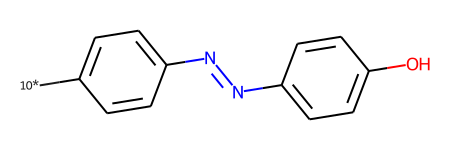

In [159]:
# Now we have our sidechains library. Here is an example of what it looks like. The attachment point of the sidechain 
# is replaced with a carbon isotop for labelling purpose. 
chainlib[2003]

In [127]:
# in the following code, we define a set of functions that perform the following tasks:
# (1) attach two predifined side-chains on two pre-defined positions of a Rhenium-bipyridine complex
# (2) remove the isotop which is a convenient for labelling but not actually present in the side chain
# (3) make an approximate geometry optimization of the molecule, build its xyz coordinates and write them in a 
# user-specified file
# (4) apply (1), (2) and (3) to a user-defined number of randomly generated sets of side-chains and randomly-generated
# attachment position. In final, this creates a set xyz-files describing randomly-generated Re-bipyridin complexes. 
# This will be used for later benchmark of semi-empirical methods.

In [128]:
#randomization-automation procedure
def spawn_Rebpy(chain_library,nchains,nrep):
    #step 1, randomly select a vector containing the chains. We suppose that there are only two lateral chains (one on each pyridine)
    #embedded in the same For loop, we can also figure out a branching for the second chain
    molvec=[]
    for j in range(0,nrep):
        print(j)
        pickabranch=[0,1,2,5,7,8,9,10]
        Vecchain=[]
        Vecbranch=[]
        Randtrace=[]
        for i in range(0,nchains):
            Randnum=random.randint(0,len(chain_library)-1)
            Randtrace.append(Randnum)
            Randbranch=random.choice(pickabranch)
            Vecchain.append(chain_library[Randnum])
            Vecbranch.append(Randbranch)
            pickabranch.remove(Randbranch)
    # After that we should have random branchment points and random sidechains. We can build the molecule
        mol=mybipybuilder(Vecchain,Vecbranch)
        print('sidechaines',Randtrace)
        print('attachment points',Vecbranch)
        mol=isotop_cleaner(mol)
        mol=carbonyls_adder(mol)
        molvec.append(mol)
    
    return molvec

In [129]:
# Builds a bipyridine from a set of side-chains and their attachement position on the bipyridine motif (by index for
# the mol object "smi") stored in two separate vectors. CAREFUL! The isotops are not removed by this function
def mybipybuilder(sidechains,nbrancher):
    smi=Chem.MolFromSmiles('c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2')
    Nats=[]
    Nt=0
    for s1 in sidechains:
        s1=Chem.MolFromSmiles(Chem.MolToSmiles(s1))
        #Nats.append(s1.GetNumAtoms())
        Nt=Nt+s1.GetNumAtoms()
        smi=Chem.CombineMols(s1,smi)
    smitext=Chem.MolToSmiles(smi)
    smi=Chem.MolFromSmiles(smitext)
    #Here get the index of each atom, because the order of appearance of the fragments in the smile is not the same as the order of combination
    print(smitext)
    smitext=smitext.split('.')
   # print(smitext)
    for ssmi in smitext:
       
        Ndum=Chem.MolFromSmiles(ssmi).GetNumAtoms()

        Nats.append(Chem.MolFromSmiles(ssmi).GetNumAtoms())
  #  print(Nats)
  #  print(smitext)
    smiedit=Chem.EditableMol(smi)
    Attachpoint=0
    smiedit.AddBond(Attachpoint,Nt+nbrancher[0])
   # print('bond formed between',Attachpoint,Nt+nbrancher[0])
    for i in range(1,len(nbrancher)):
     #   print(i,Nats[i-1])
        Attachpoint=Attachpoint+Nats[i-1]
        smiedit.AddBond(Attachpoint,Nt+nbrancher[i])
     #   print('bond formed between',Nats[i-1],Nt+nbrancher[i])
    newsmi=smiedit.GetMol()
   
    return newsmi

In [130]:
# removes the isotopes and atach the isotop neighbours together
def isotop_cleaner(mol):
    #step 1: identify the index of the isotopes
    indx=mol.GetSubstructMatches(Chem.MolFromSmiles('*'))
    indx2=[]
    for i in indx:
        indx2.append(i[0])
    #Step 2: identify the atoms bonded to the isotops
    bound=[]
    j=0
    for i in indx2:
        bound.append([])
        for k in range(0,mol.GetNumAtoms()):
            Hello=mol.GetBondBetweenAtoms(i,k)
            if type(Hello) == Chem.rdchem.Bond:
                bound[j].append(k)
                print(bound)
        j=j+1
    #Step 3 Now we remove the isotops and reattach the neighbours of the isotops:
    j=0
    moledit=Chem.EditableMol(mol)
    for i in range(0,len(indx)):
        moledit.RemoveAtom(indx2[i])
        # Now we need to change the index in bound if there needs to be
        j=0
        for j in range(0,len(bound)):
         #   print(bound,j)
            if bound[j][0] > indx2[i]:
                bound[j][0]=bound[j][0]-1
            if bound[j][1] > indx2[i]:
                bound[j][1]=bound[j][1]-1
        j=0
        for j in range (i,len(indx)):
            if indx2[j] > indx2[i]:
                indx2[j]=indx2[j]-1
        moledit.AddBond(bound[i][0],bound[i][1])
    mol=moledit.GetMol()
   # mol=Chem.RemoveHs(mol)
    mol2=Chem.MolToSmiles(mol)
    mol2=mol2.replace('~','-')
    mol=Chem.MolFromSmiles(mol2,sanitize=False)
   # mol=Chem.RemoveHs(mol)
    return mol

In [160]:
#Adds the bipyridine to a Re(CO)3 motif.
def carbonyls_adder(mol):
    mol2=Chem.MolToSmiles(mol)
    mol3=mol2.split('[Re]')
    mol2=mol3[0]+'[Re](C#[O+])(C#[O+])(C#[O+])'+mol3[1]
    mol=Chem.MolFromSmiles(mol2)
    return mol

In [165]:
#Before going to the next step, we must also remove the "bidentate" side-chains for simplicity reasons
delete_sick=[]
for i in range(0,len(chainlib)):
    if len(chainlib[i].GetSubstructMatches(Chem.MolFromSmiles('*'))) != 1:
        delete_sick.append(chainlib[i])
        

In [167]:
for i in delete_sick:
    chainlib.remove(i)

In [168]:
len(chainlib)

5613

In [172]:
#Now the random library can be generated
nchains=2
nrep=100
sample=spawn_Rebpy(chainlib,nchains,nrep)

0
*C#Cc1cc(OCCCCCCCCCCCC)c(OCCCCCCCCCCCC)c(OCCCCCCCCCCCC)c1.[10*]C1N[C@@H](C(C)C)C(c2ccccc2)(c2ccccc2)O1.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [3379, 3868]
attachment points [5, 7]
[[1]]
[[1, 74]]
[[1, 74], [49]]
[[1, 74], [49, 76]]
1
*/C=C/c1ccc(N(CC)CCOC2CCCCO2)cc1.[10*]c1nc2ccccc2n1CCCCCC[P+]([O-])(O)O.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [5295, 4967]
attachment points [7, 8]
[[1]]
[[1, 48]]
[[1, 48], [22]]
[[1, 48], [22, 49]]
2
*C(=O)NC(COCCC(=O)O)(COCCC(=O)O)COCCC(=O)O.*c1cc2[nH]c1cc1nc(c(-c3cc(C(C)(C)C)cc(C(C)(C)C)c3)c3ccc([nH]3)c(-c3cc(C(C)(C)C)cc(C(C)(C)C)c3)c3nc(c2-c2cc(C(C)(C)C)cc(C(C)(C)C)c2)C=C3)C=C1.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [1964, 979]
attachment points [5, 9]
[[1]]
[[1, 98]]
[[1, 98], [27]]
[[1, 98], [27, 102]]
3
[2*]C(=O)C(C)Br.[2*]C(OC)C(C)(C)C.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [274, 1363]
attachment points [8, 5]
[[1]]
[[1, 22]]
[[1, 22], [7]]
[[1, 22], [7, 19]]
4
[2*]c1nnc(-c2ccc(C(C)(C)C)cc2)c(-c2ccc(C(C)(C)C)cc2)n1.[8*]CS.c1

RDKit ERROR: [13:26:39] Explicit valence for atom # 25 S, 7, is greater than permitted


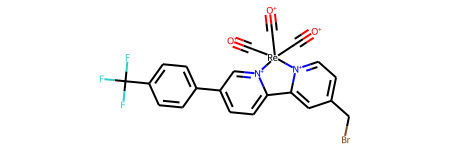

In [176]:
# Here is one example of generated bipyridine:
sample[93]

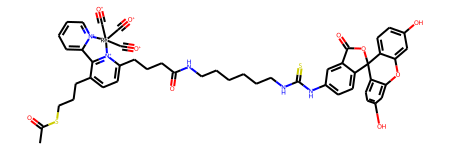

In [177]:
# Another example...
sample[57]

In [178]:
#Finally, we now write the content of the sample list into xyz files in a chosen directory. For that, we create
# an approximate 3D structure using the ETKDG method as implemented in Rdkit. Note that the starting geometry 
# is nowhere near an equilibrium geometry and will require an additionnal geometry optimization. 
# FF optimization with Re is not implemented in Rdkit unfortunately. However, the embedding allows a starting geometry 
# with not-too-awful angles and bond lengths, and most importantly, no overlapping atoms.
# This way, with the appropriate scripts/QM/FF package, the starting geometry can be directly optimized without 
# additional user input.

In [179]:
# write a specified number of xyz files. Also stores the molecules under the form of smiles in a text file 
# in the same folder, as well as a list of the total charge for each complex 
# (CAREFUL:he charge has a systematice error of +5 for each system in the present implementation due to the arbitrary 
# 0 charge of the rhenium) 
def write_xyzfiles(chainlib,nchains,nrep,place):
    try:
        sample=spawn_Rebpy(chainlib,nchains,nrep)
    except:
        pass
    indx=0
    place2=place
    for mol in sample:
        xyz_generator(mol,place,indx)
        indx=indx+1
    smiles_generator(place2,sample)
    return sample

In [180]:
def smiles_generator(place,samp):
    placeX=place+'/smiles-index'
    print(place)
    file1=open(placeX,'w+')
    for sa in samp:
        file1.write(Chem.MolToSmiles(sa)+'\n')
    file1.close()
    placeY=place+'/chargefile'
    file1=open(placeY,'w+')
    for sa in samp:
        file1.write(str(Chem.GetFormalCharge(sa))+'\n')
    file1.close()

In [182]:
# and the proper program to generate and store the 3d structure of a given Mol object
def xyz_generator(mol,place,indx):  
    if type(mol) is not None:
        place=place+'/Rebipy-'+str(indx)+'.xyz'
        mol2=Chem.AddHs(mol)
        N=mol2.GetNumAtoms()
        AllChem.EmbedMolecule(mol2,randomSeed=0xf00d)
        print(Chem.MolToMolBlock(mol2),file=open(place,'w+'))
        #file.close()
        file=open(place,'r')
        lines=file.readlines()
        file.close()
        file=open(place,'w+')
        file.write(str(N)+'\n')
        file.write('This xyz file has been randomly generated!\n')
        for i in range (4,N+4):
            linesp=lines[i].split()
            linetowrite=linesp[3]+' '+linesp[0]+' '+linesp[1]+' '+linesp[2]+'\n'
            file.write(linetowrite)
    else:
        place=place+'/Rebipy-'+str(indx)+'.xyz'
        file=open(place,'w+')
        file.write('Empty mol file :(')
        print('ho-ho, we have a problem...')
    file.close

In [183]:
# Now we can give it a try...
place='/Users/tarrago/Documents/personal-project' #This is where I want my xyzfiles stored
echantillon=write_xyzfiles(chainlib,nchains,nrep,place)

0
[2*]C(=O)C(=O)c1cccc(C)n1.[8*]c1cc(OCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)cc(OCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)c1.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [2373, 3582]
attachment points [9, 0]
[[1]]
[[1, 74]]
[[1, 74], [13]]
[[1, 74], [13, 65]]
1
[10*]B(N(C)C)N(C)C.[2*]c1cn(Cc2ccccc2)nn1.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [740, 1547]
attachment points [7, 2]
[[1]]
[[1, 28]]
[[1, 28], [9]]
[[1, 28], [9, 23]]
2
*C([Si](C)(C)C)[Si](C)(C)C.[1*]c1nc2ccccc2n1-c1ccc(C)cc1.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [2500, 4562]
attachment points [0, 9]
[[1]]
[[1, 27]]
[[1, 27], [11]]
[[1, 27], [11, 36]]
3
*C(O)=Nc1ccnc2c1ccc1c(C)ccnc12.[9*]/C=C/c1cccn1CCCCCCCCCCCC.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [1935, 4987]
attachment points [7, 1]
[[1]]
[[1, 46]]
[[1, 46], [20]]
[[1, 46], [20, 40]]
4
[2*]c1c[nH]c2ccccc12.[9*]/C=C/c1cc(OCCCCCC)c(/C=C/c2cc(OCCCCCC)c(C=C)cc2OCCCCCC)cc1OCCCCCC.c1cc[n+]2c(c1)-c1cccc[n+]1[Re]2
sidechaines [3033, 330]
attachment poi

RDKit ERROR: [13:42:39] UFFTYPER: Unrecognized atom type: Re6 (16)
RDKit ERROR: [13:42:39] UFFTYPER: Unrecognized atom type: Re6 (28)
RDKit ERROR: [13:42:39] UFFTYPER: Unrecognized atom type: Re6 (13)
RDKit ERROR: [13:42:40] UFFTYPER: Unrecognized atom type: Re6 (25)
RDKit ERROR: [13:42:40] UFFTYPER: Unrecognized atom type: Re6 (34)
RDKit ERROR: [13:42:40] UFFTYPER: Unrecognized atom type: Re6 (26)
RDKit ERROR: [13:42:41] UFFTYPER: Unrecognized atom type: Re6 (28)
RDKit ERROR: [13:42:41] UFFTYPER: Unrecognized atom type: Re6 (48)
RDKit ERROR: [13:42:42] UFFTYPER: Unrecognized atom type: Re6 (14)
RDKit ERROR: [13:42:42] UFFTYPER: Unrecognized atom type: Re6 (62)
RDKit ERROR: [13:42:43] UFFTYPER: Unrecognized atom type: Re6 (18)
RDKit ERROR: [13:42:43] UFFTYPER: Unrecognized atom type: Re6 (27)
RDKit ERROR: [13:42:43] UFFTYPER: Unrecognized atom type: Re6 (25)
RDKit ERROR: [13:42:43] UFFTYPER: Unrecognized atom type: Re6 (19)
RDKit ERROR: [13:42:43] UFFTYPER: Unrecognized atom type: Re6 

/Users/tarrago/Documents/personal-project


RDKit ERROR: [13:43:23] UFFTYPER: Unrecognized atom type: Re6 (9)


In [ ]:
# We can see that the program complains a lot about the Re, as emphasize above. But the rest of the atoms are decently 
# organized, if not optimized. The xyzfiles are stored in the specified diretory, ready to be used by a QM package,
# or visualized with an appropriate software (chemcraft, chimera, avogadto...)